# KPrototypes(n=8) Results

From the previous notebook, we have identified that `n=4` is the optimum number of clusters.  
However, there exist a huge cluster `0` which we desire to break up more.

**Setting up**

In [1]:
%load_ext kedro.ipython
%load_ext autoreload
%matplotlib inline
%autoreload 2

[04/16/23 18:44:12] INFO     Resolved project path as: /home/eckt/Documents/usg.                    ]8;id=22062;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=57232;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/16/23 18:44:14] INFO     Kedro project usg                                                      ]8;id=524437;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=685473;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=761686;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=572943;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

[04/16/23 18:44:15] INFO     Registered line magic 'run_viz'                                        ]8;id=773070;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=734828;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#110\110]8;;\

In [2]:
import pandas as pd
import polars as pl
import numpy as np

from matplotlib import rc_context
import matplotlib.pyplot as plt
import seaborn as sb
from seaborn.objects import Plot
import seaborn.objects as so

from kmodes.kprototypes import KPrototypes

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

In [3]:
X: pd.DataFrame = catalog.load('train')
scaler = catalog.load('model@scaler')

                    INFO     Loading data from 'train' (CSVDataSet)...                          ]8;id=525155;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=147764;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

[04/16/23 18:44:16] INFO     Loading data from 'model@scaler' (PickleDataSet)...                ]8;id=872961;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=378671;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
def cluster(n=1):
  model = KPrototypes(n_clusters = n, n_jobs = -1, random_state = 0)
  log.info("Performing clustering for n=%d", n)
  y = model.fit_predict(X=X[columns], categorical=list(range(0, len(categorical))))
  log.info("cost[%d]=%.2f", n, model.cost_)
  return model, y

model = None
y = None
if catalog.exists('model@kprototypes@8'):
    model = catalog.load('model@kprototypes@8')
    y = catalog.load('labels@kprototypes@8')
else:
    model, y = cluster(n=8)
    catalog.save('model@kprototypes@8', model)
    catalog.save('labels@kprototypes@8', pd.Series(y, name='cluster'))

X['cluster'] = y

                    INFO     Performing clustering for n=8                                          ]8;id=419207;file:///tmp/ipykernel_4096/2556956117.py\2556956117.py]8;;\:]8;id=220030;file:///tmp/ipykernel_4096/2556956117.py#3\3]8;;\

[04/16/23 18:48:19] INFO     cost[8]=1044.36                                                        ]8;id=647440;file:///tmp/ipykernel_4096/2556956117.py\2556956117.py]8;;\:]8;id=224259;file:///tmp/ipykernel_4096/2556956117.py#5\5]8;;\

                    INFO     Saving data to 'model@kprototypes@8' (PickleDataSet)...            ]8;id=684938;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=347404;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#382\382]8;;\

                    INFO     Saving data to 'labels@kprototypes@8' (CSVDataSet)...              ]8;id=387134;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=893246;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [5]:
X = X.set_index('appid')
X['cluster'] = X['cluster'].astype(pd.CategoricalDtype(categories=[0,1,2,3,4,5,6,7]))

# Centroids

In [6]:
centroids_u = pd.DataFrame(model.cluster_centroids_, columns=numerical+categorical) # KPrototypes handles categorical last
centroids_u

,year,achievements,required_age,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,...,median_playtime,english,windows,mac,linux,Single-player,Multi-player,Indie,Action,Casual
0,0.998762,0.001951,0.000224,0.013375,0.000425,0.112705,0.151174,1.000000,0.000091,0.000114,...,0.000588,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.998179,0.003236,0.921191,0.029281,0.005465,0.223292,0.156852,0.991243,0.003216,0.003703,...,0.002002,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.998672,0.003839,0.000408,0.019790,0.002658,0.431209,0.199747,0.995956,0.001437,0.001403,...,0.001337,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
3,0.998884,0.004541,0.000574,0.010960,0.000144,0.118720,0.094730,0.595894,0.000006,0.000019,...,0.000073,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.998565,0.003643,0.000040,0.015643,0.001070,0.233580,0.171596,0.999523,0.000442,0.000330,...,0.001343,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
5,0.998961,0.006390,0.000453,0.009735,0.000274,0.127969,0.182914,1.000000,0.000059,0.000059,...,0.000618,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
6,0.999116,0.009270,0.000184,0.010870,0.000339,0.145051,0.282822,1.000000,0.000068,0.000113,...,0.000377,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
7,0.998416,0.002895,0.000327,0.020227,0.001561,0.192529,0.137892,1.000000,0.000462,0.000866,...,0.000826,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [7]:
centroids = pd.DataFrame(scaler.inverse_transform(centroids_u[scaler.feature_names_in_]), columns=scaler.feature_names_in_)
centroids.round(2)

,english,windows,mac,linux,Single-player,Multi-player,Indie,Action,Casual,year,...,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime
0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2016.50,...,5.64,84945.45,2.03,2.42,3.00,240.02,55.60,4.39,87.99,112.00
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2015.32,...,12.36,1093012.26,4.02,2.51,2.97,8504.74,1803.82,5.71,572.10,381.60
2,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2016.32,...,8.35,531672.79,7.76,3.20,2.99,3798.73,683.15,5.21,302.20,254.77
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2016.75,...,4.63,28867.64,2.14,1.52,1.79,15.48,9.43,2.32,13.44,13.90
4,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2016.10,...,6.60,213919.47,4.20,2.75,3.00,1168.09,160.92,7.08,261.14,256.02
5,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2016.90,...,4.11,54720.14,2.30,2.93,3.00,157.31,28.63,4.52,90.57,117.88
6,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2017.22,...,4.59,67807.00,2.61,4.53,3.00,179.18,55.12,3.33,74.78,71.96
7,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2015.80,...,8.54,312116.03,3.47,2.21,3.00,1220.48,421.62,4.67,178.45,157.39


In [8]:
counts = X['cluster'].value_counts()

viz = centroids_u.reset_index(names='cluster').melt(id_vars='cluster')
viz['categorical'] = viz['variable'].map(lambda x: x in categorical)
centroid_viz_data = (viz
                     .reset_index(names='order')
                     .set_index(['cluster', 'variable'])
                     .join(centroids
                           .reset_index(names='cluster')
                           .melt(id_vars='cluster', value_name='orig')
                           .set_index(['cluster', 'variable'])
                           .round(2)
                     )
                     .reset_index('cluster')
                     .join(X[columns].median()
                           .to_frame('median'),
                           how='left'
                     )
                     .reset_index(names='variable')
                     .set_index('cluster')
                     .sort_values(by='order'))

def centroid_viz(cluster=0):
    df = centroid_viz_data.loc[cluster].reset_index(drop=True)
    return (Plot(data=df, y="variable", x="value", color="categorical")
    .add(so.Bar(width=0.05, color="lightgrey", alpha=0.6), baseline="median", legend=False)
    .add(so.Dot())
    .add(so.Dot(alpha=0.6), x="median")
    .add(so.Text(halign="left", fontsize=8, offset=8, color="black"), text="orig")
    .label(title=f"Visualisation of cluster {cluster} centroid (n={counts[cluster]})")
    .limit(x=(-0.05,1.2)))

In [9]:
cluster_viz_data = X.melt(id_vars='cluster')#.set_index('cluster')

def cluster_viz(cluster=0):
    df = cluster_viz_data.set_index('cluster').loc[cluster].reset_index(drop=True)
    return (sb.catplot(data=df, 
                       x='value', 
                       y='variable', 
                       kind='box', 
                       fliersize=2, 
                       flierprops={"marker": "x"}, 
                       medianprops={"color": "orange"}, 
                       showcaps=False)
            .set(title=f"Visualisation of cluster {cluster} (n={counts[cluster]})"))

## At a glance

**Number of games per cluster**

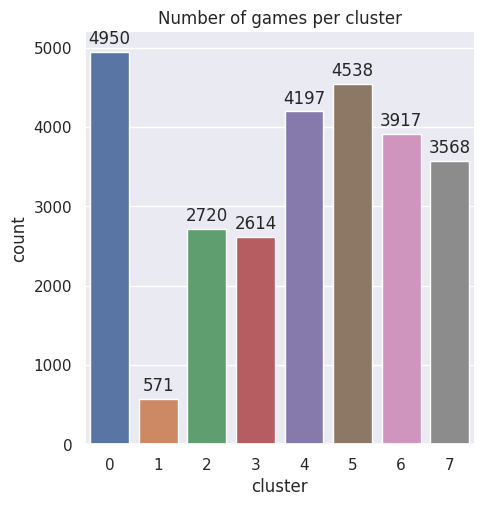

In [10]:
catplot_xlabel(sb.catplot(data=X, x='cluster', kind='count').set(title="Number of games per cluster"))

**Centroid visualisation**

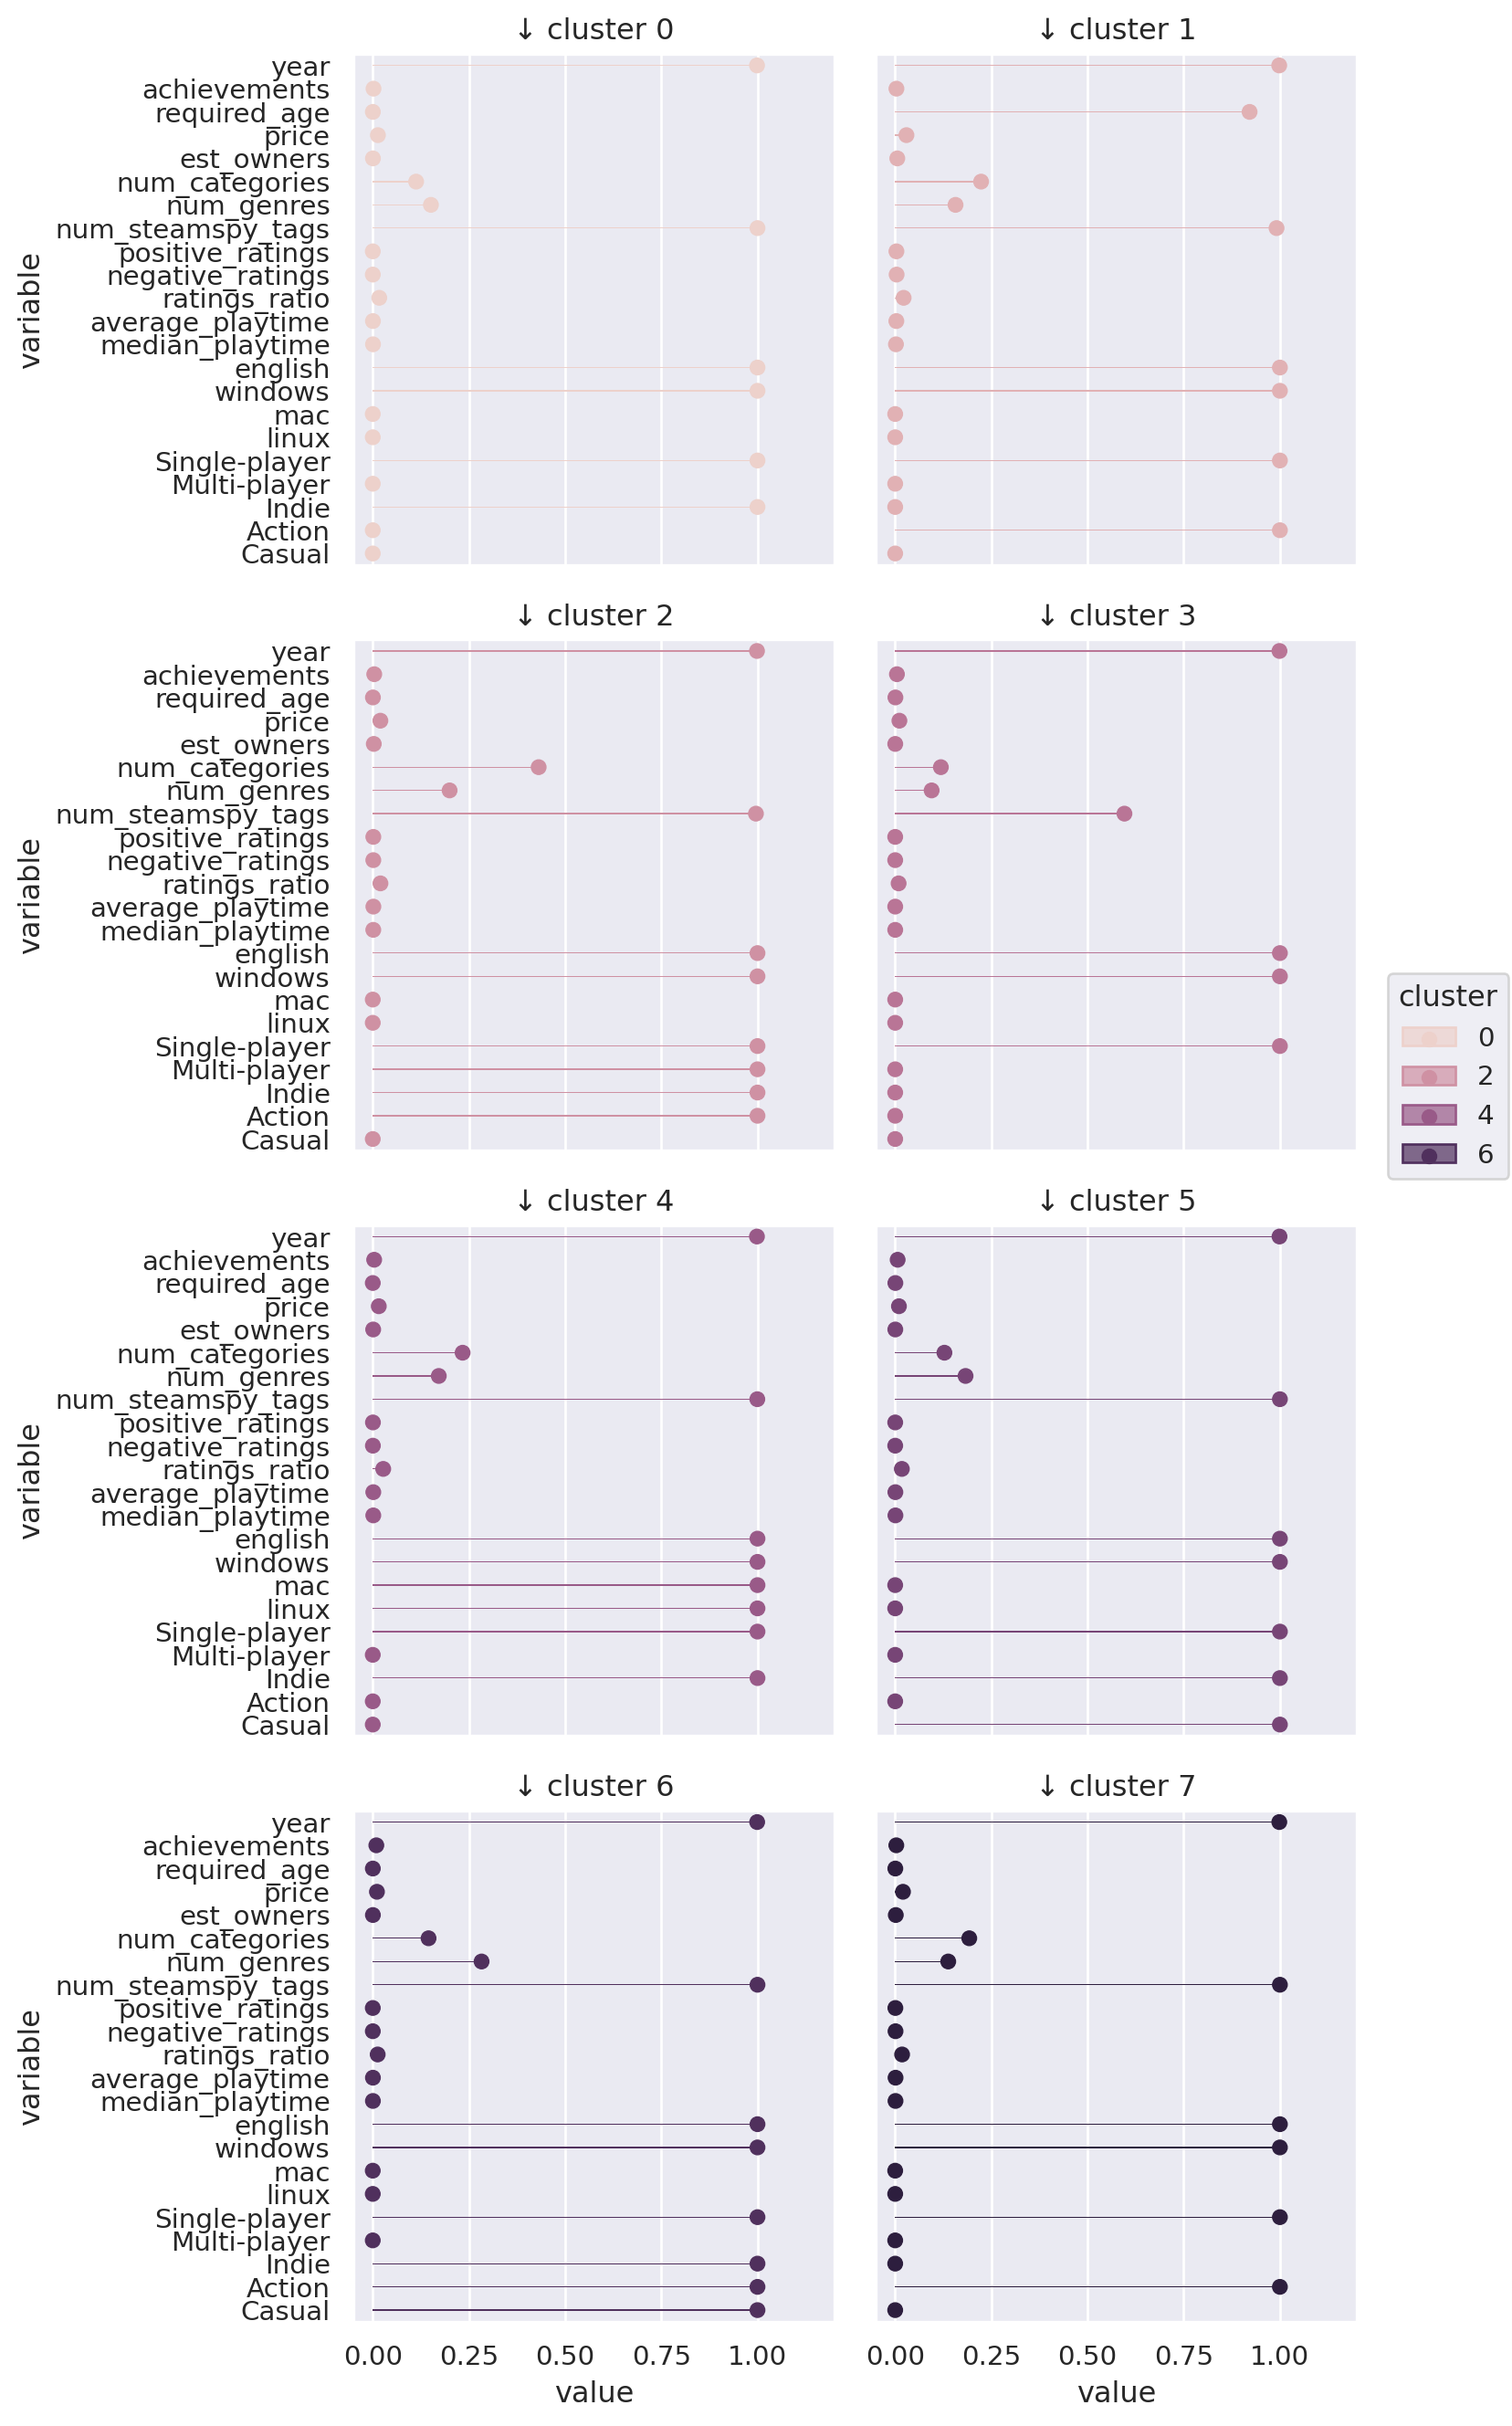

In [25]:
(Plot(data=centroid_viz_data.reset_index(), y="variable", x="value", color="cluster")
 .limit(x=(-0.05,1.2))
 .layout(size=(8,14))
 .facet(col="cluster", wrap=2)
 .add(so.Bar(width=0.05))
 .add(so.Dot())
 .label(col="↓ cluster"))

**Distribution per feature by cluster visualisation**

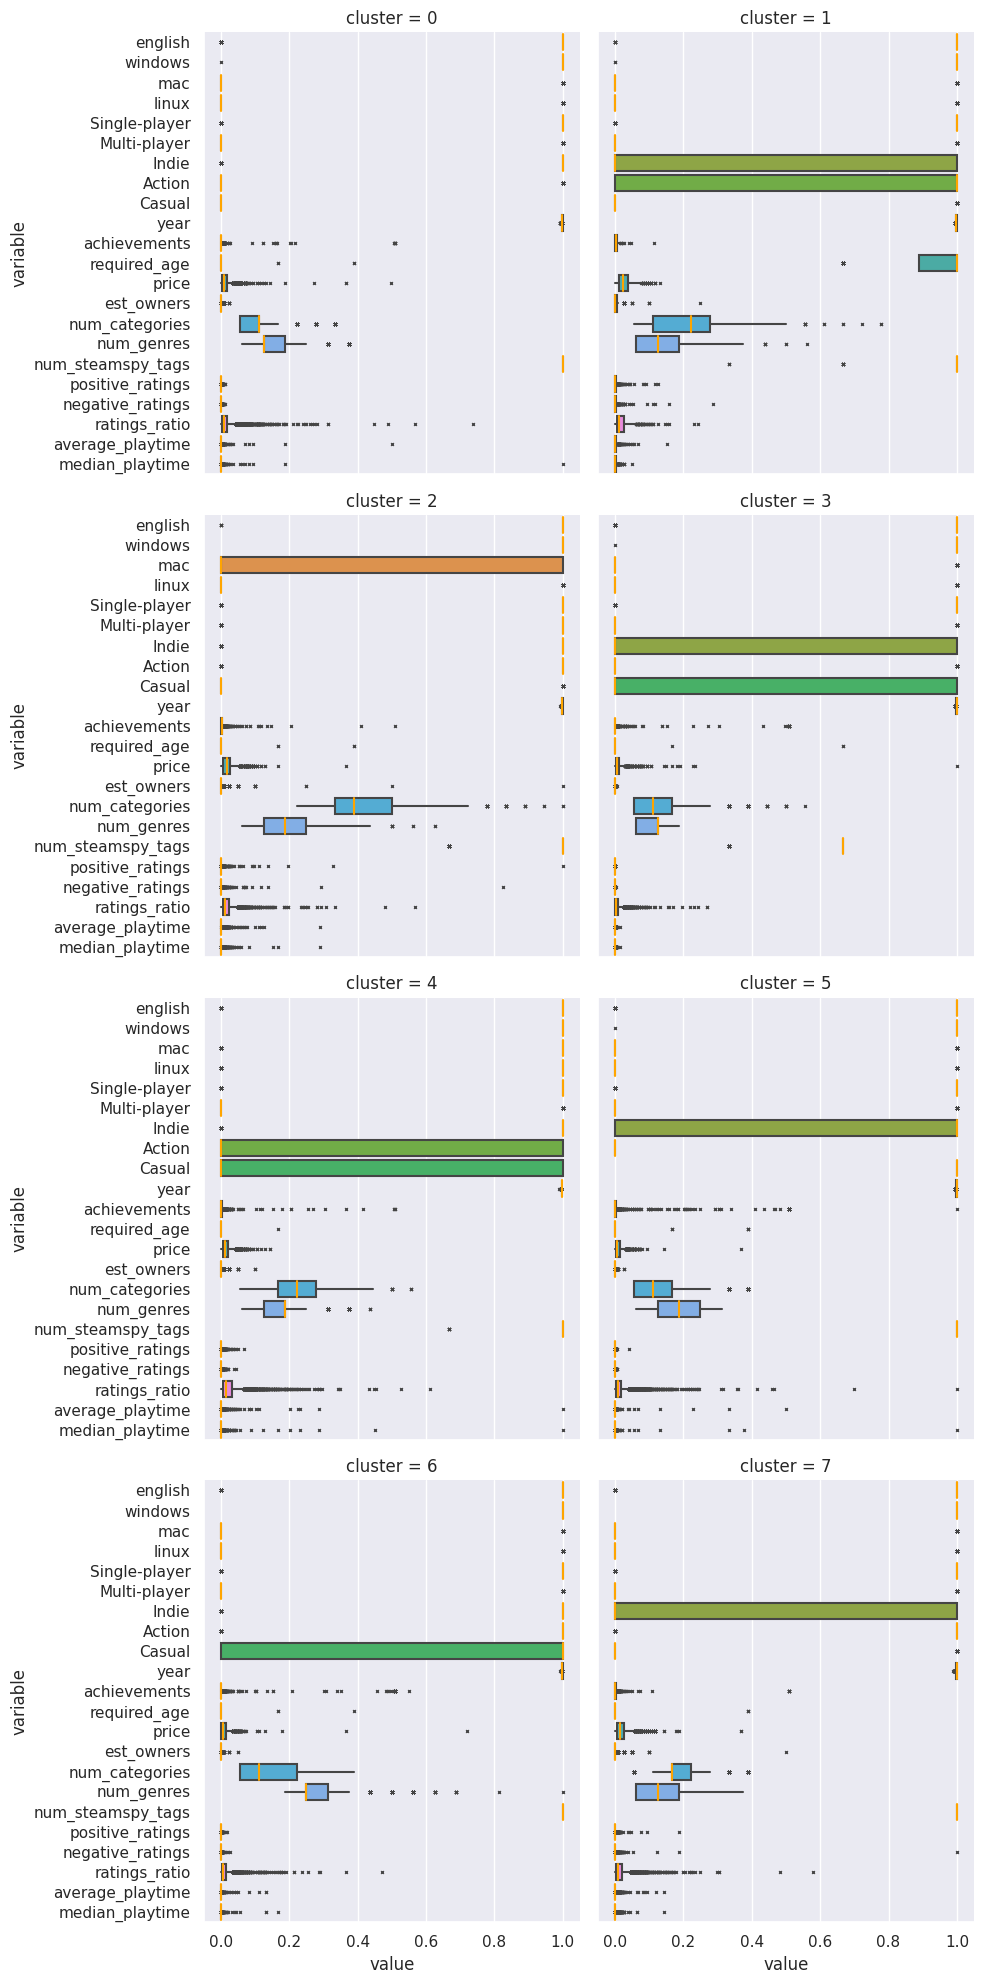

In [12]:
sb.catplot(data=cluster_viz_data, x='value', y='variable', col='cluster', col_wrap=2, kind='box', fliersize=2, flierprops={"marker": "x"}, medianprops={"color": "orange"}, showcaps=False)

# Cluster 0

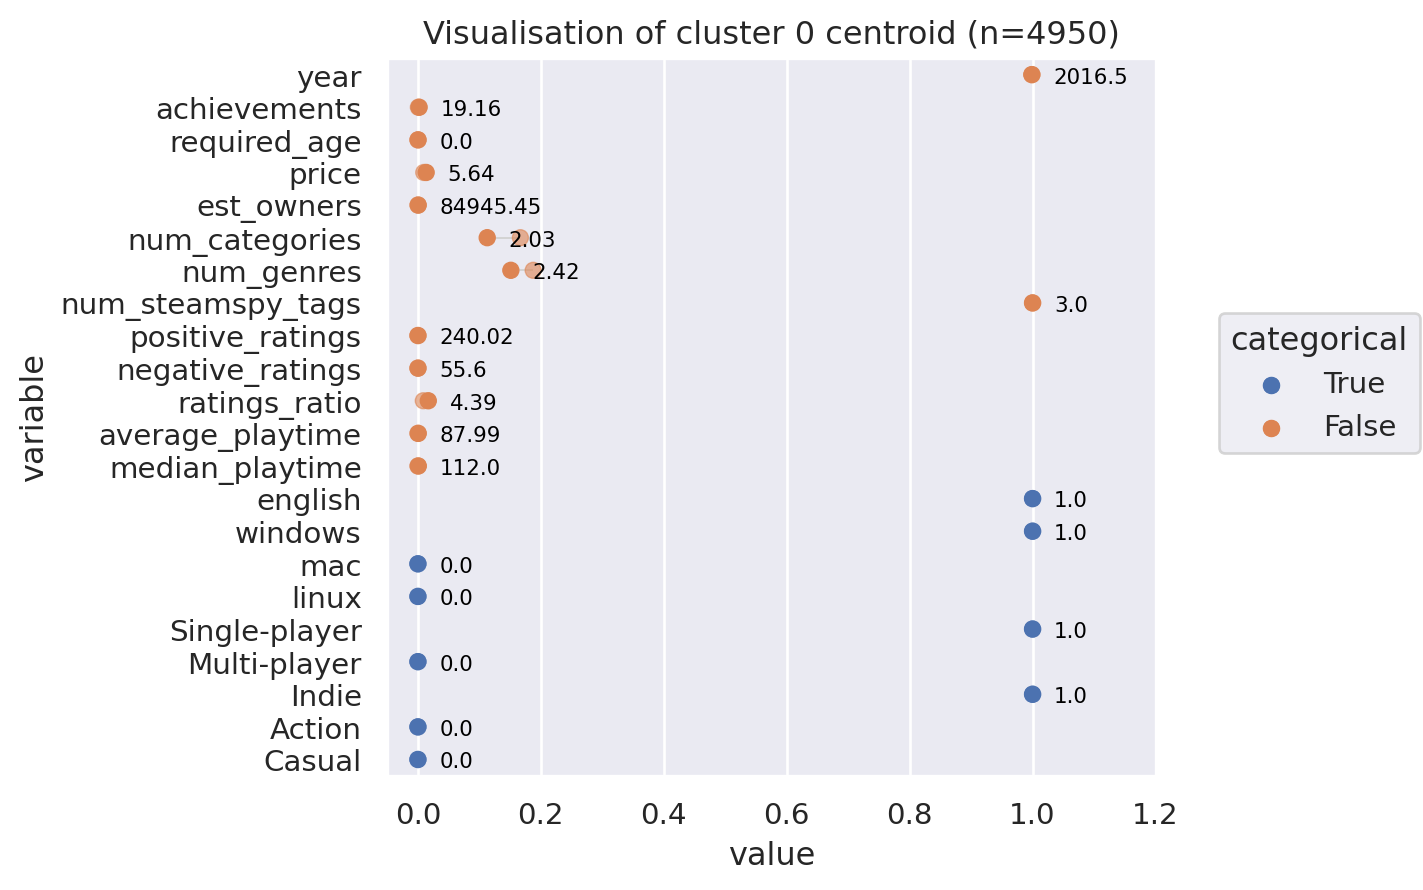

In [13]:
centroid_viz(0)

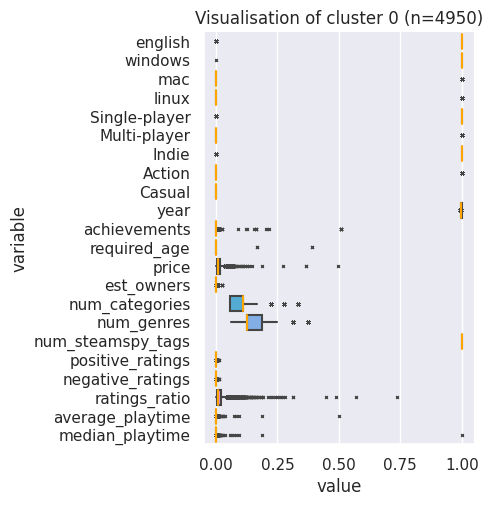

In [14]:
cluster_viz(0)

# Cluster 1

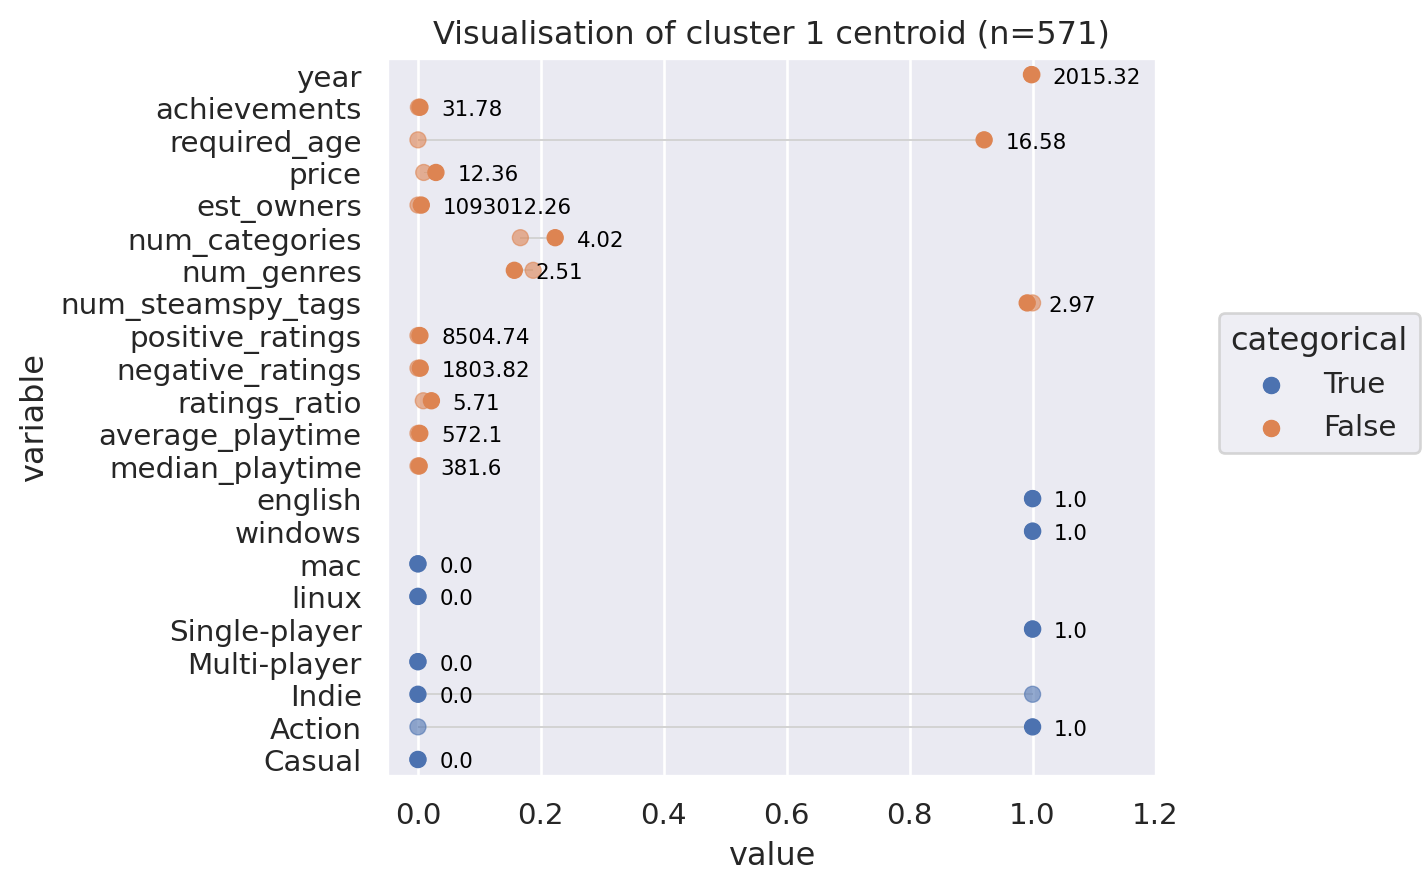

In [15]:
centroid_viz(1)

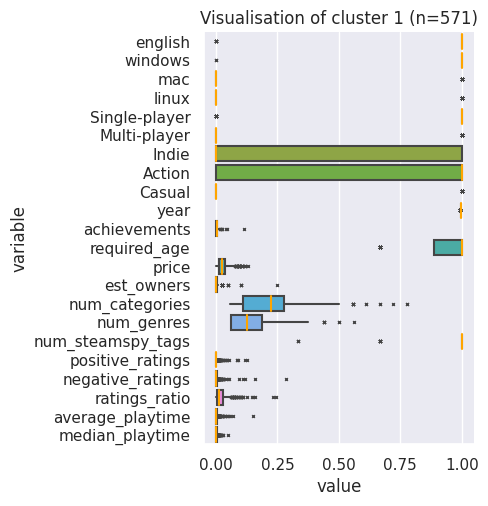

In [16]:
cluster_viz(1)

# Cluster 2

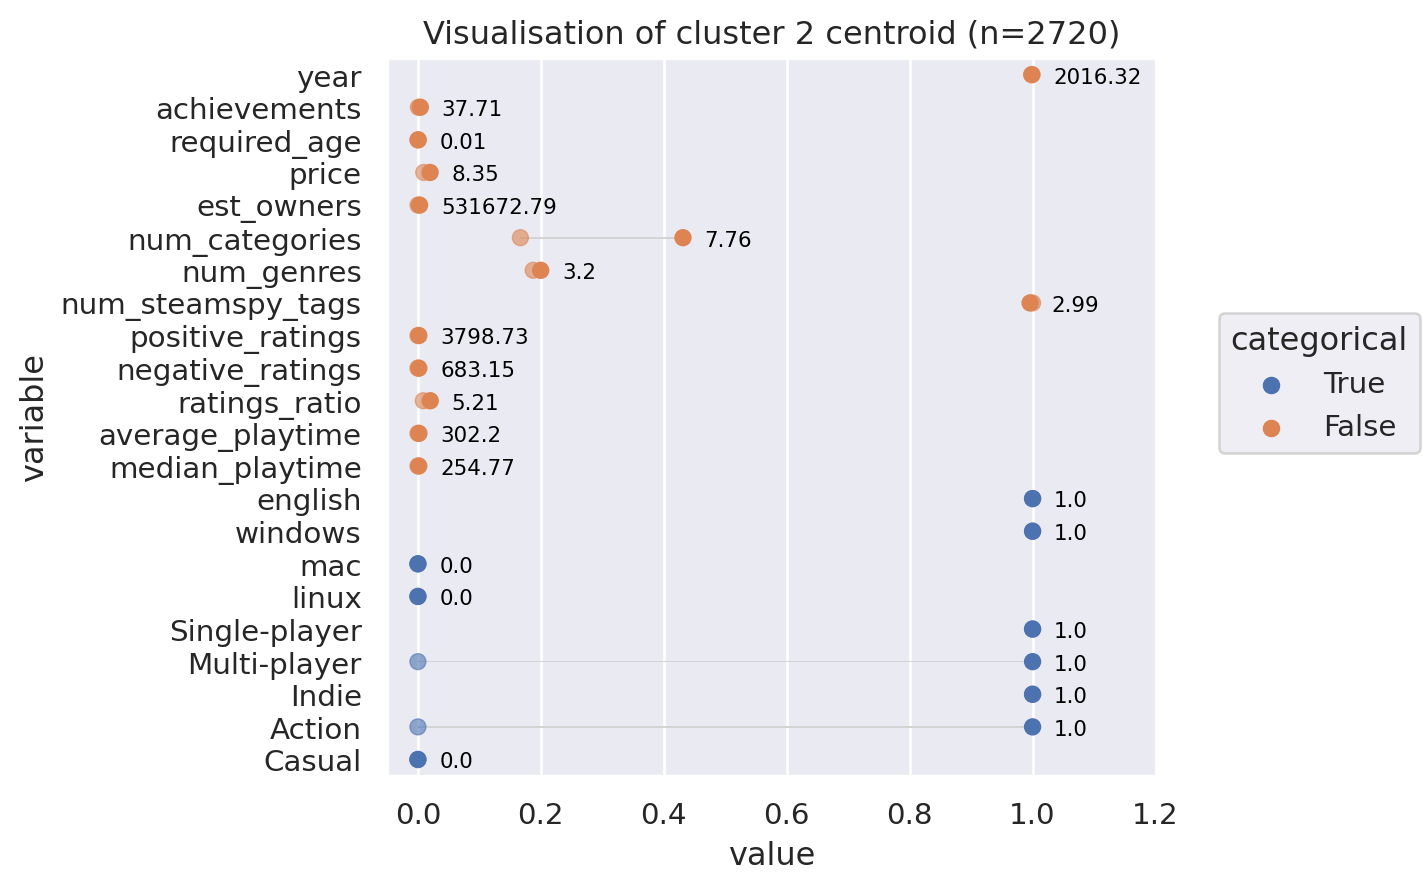

In [17]:
centroid_viz(2)

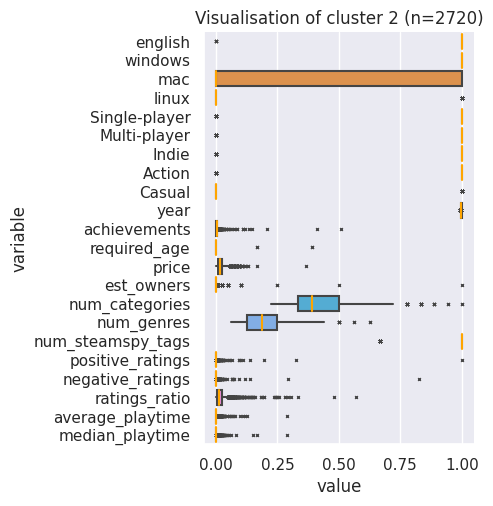

In [18]:
cluster_viz(2)

# Cluster 3

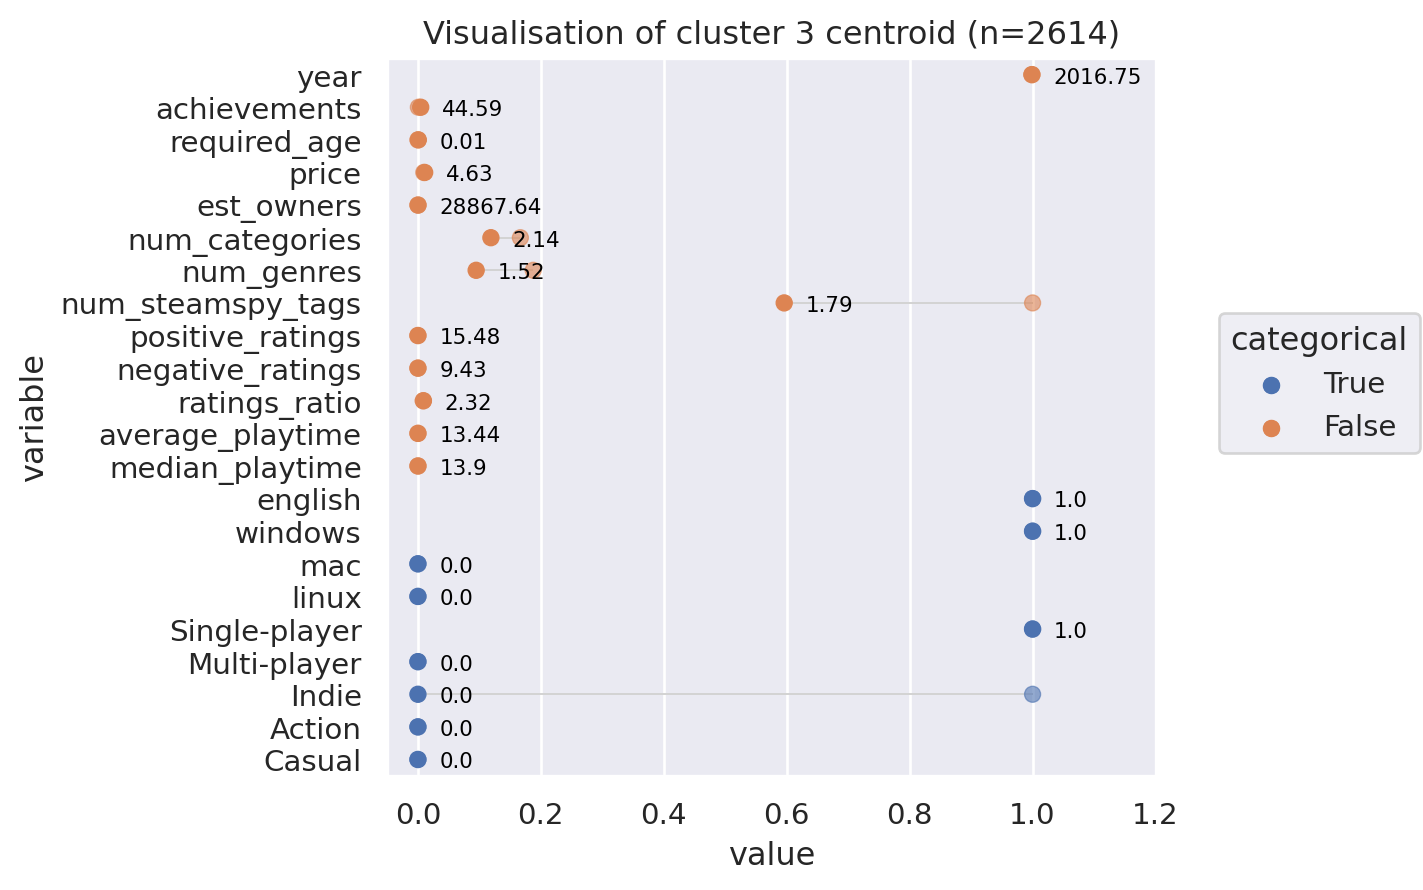

In [19]:
centroid_viz(3)

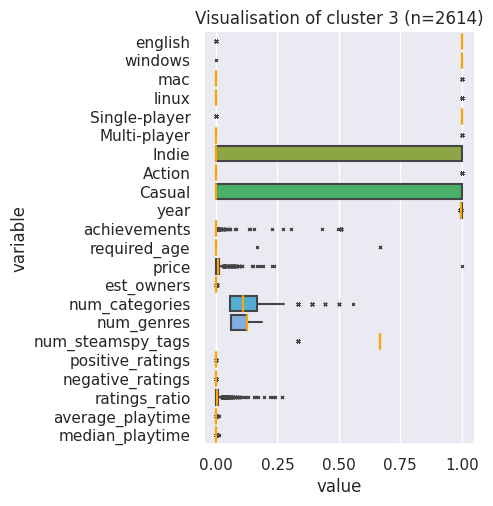

In [20]:
cluster_viz(3)

# Cluster 4

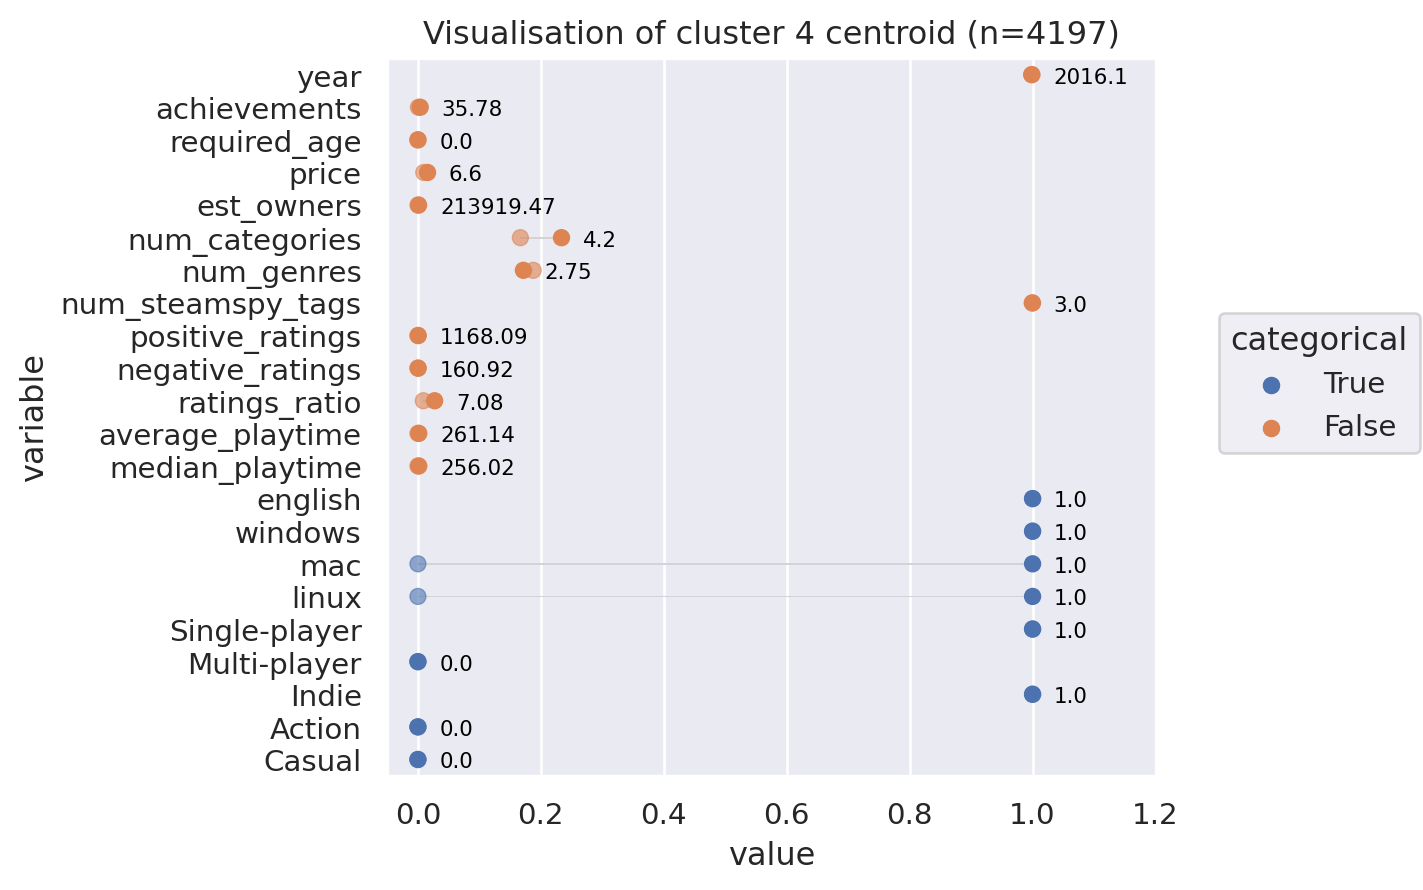

In [21]:
centroid_viz(4)

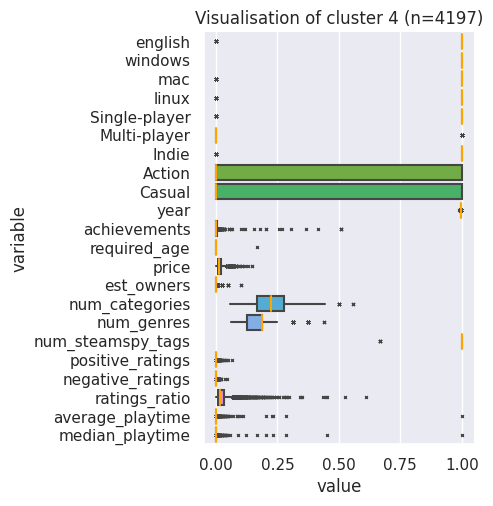

In [22]:
cluster_viz(4)

# Cluster 5

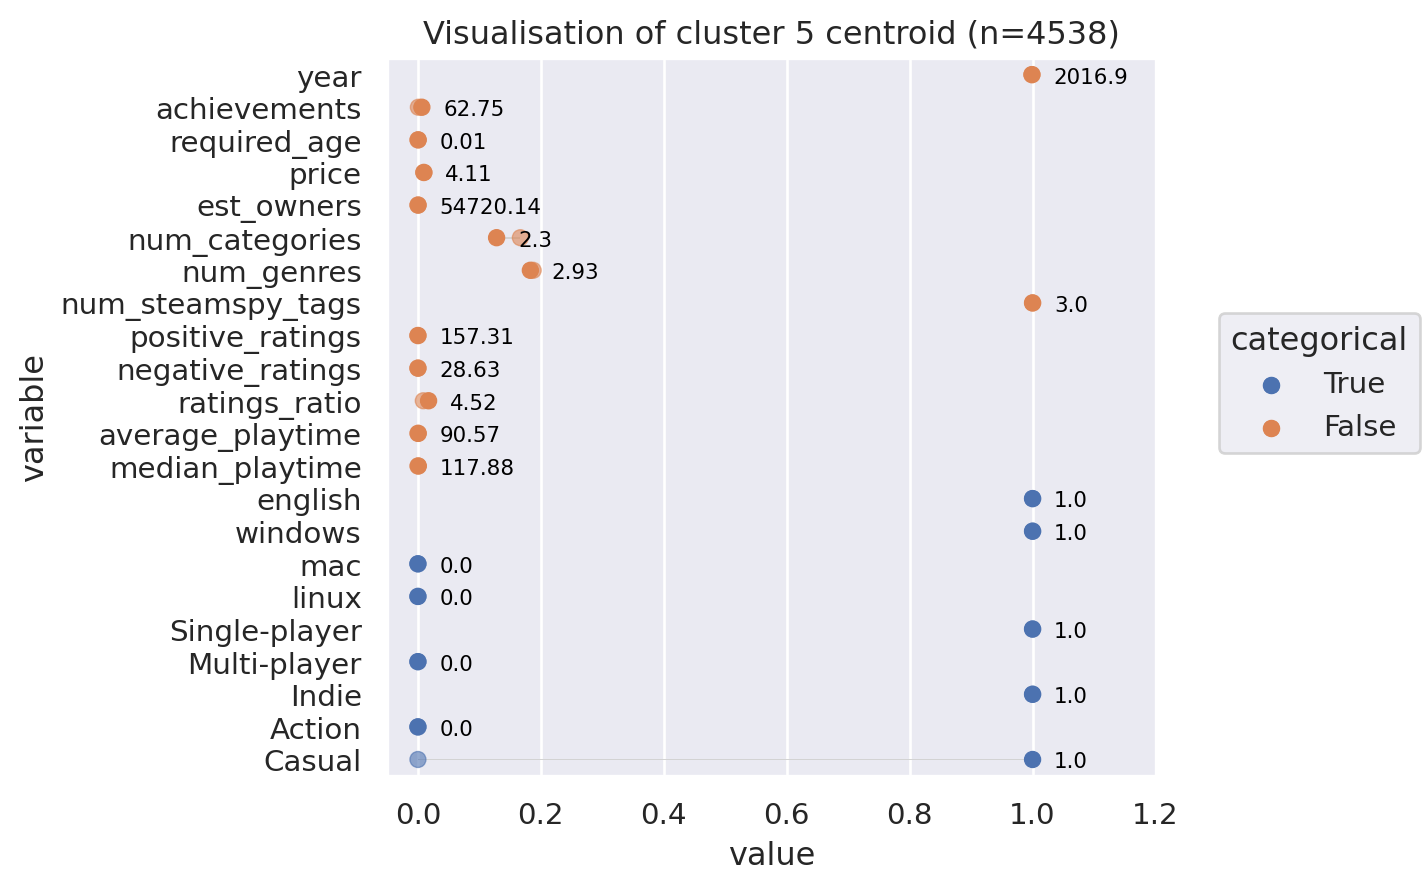

In [23]:
centroid_viz(5)

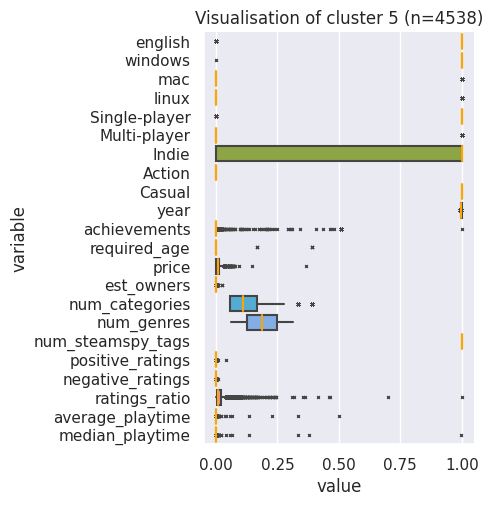

In [24]:
cluster_viz(5)

# Cluster 6

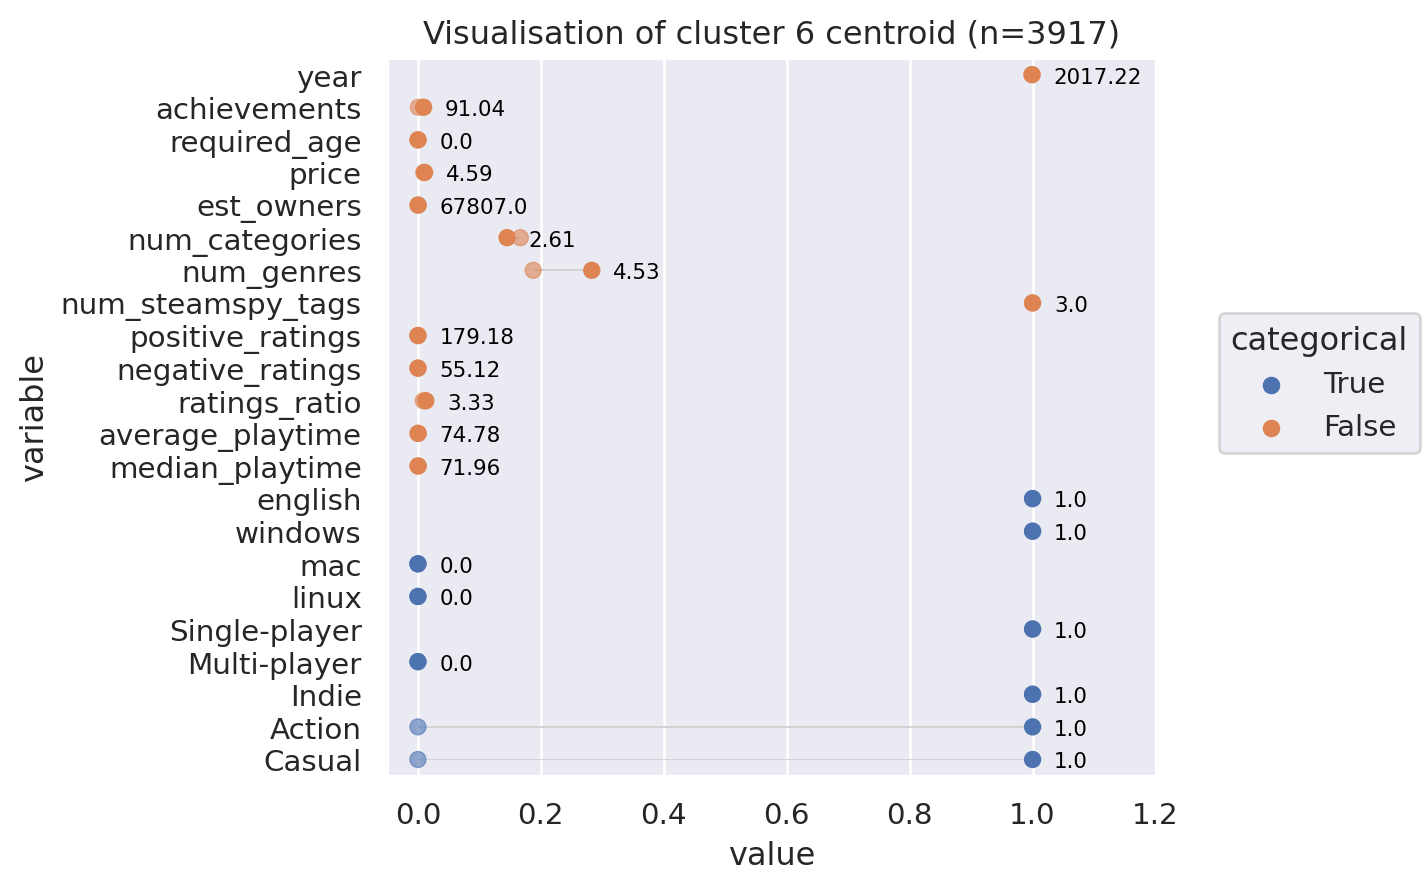

In [26]:
centroid_viz(6)

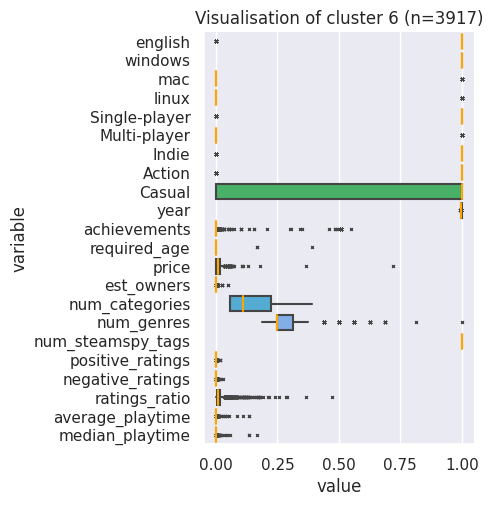

In [27]:
cluster_viz(6)

# Cluster 7

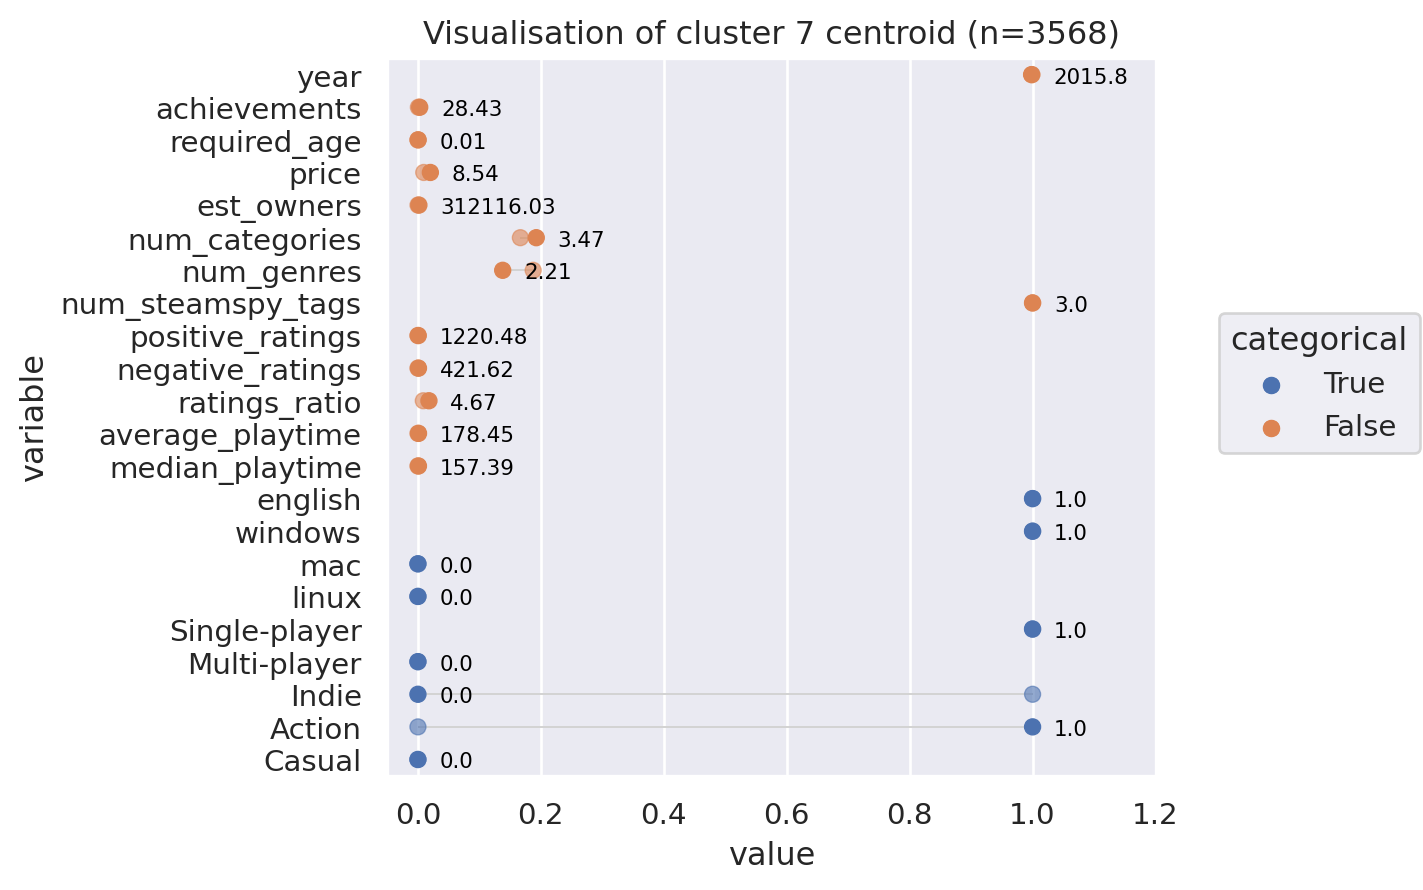

In [28]:
centroid_viz(7)

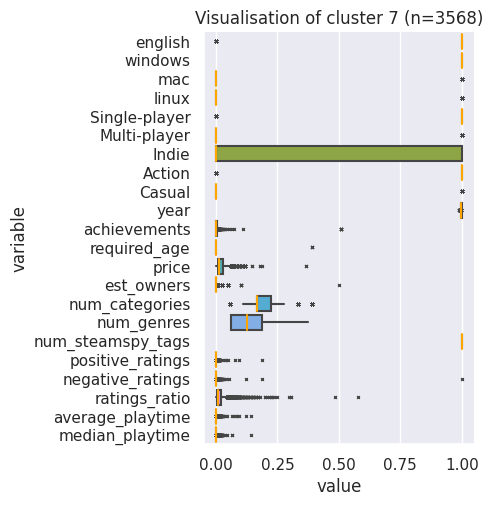

In [29]:
cluster_viz(7)